In [1]:
import os
import cv2 as cv
import sys
import time
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf


warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
IMG_CHANNELS = 3

Using TensorFlow backend.


In [26]:
def acc_comp(msk, preds_test_t): #Takes as input 2D masks and 2D predictions
    
    act = msk.reshape(len(msk),1)
    pr = preds_test_t

    c = act == pr #acc
    d = act & pr #true negative
    e = act | pr #true positive
    neg = act.sum()
    pos = (len(act))-act.sum()

    TN = round(float(d.sum()),6)
    FN = round(float(pr.sum()-d.sum()),6)
    TP = round(float((len(act))-e.sum()),6)
    FP = round(float(e.sum()-pr.sum()),6)
    acc = round(float(c.sum())/(len(act)),6)

    acc2 = float(TP+TN)/(TP+TN+FP+FN)
    mean_TP = round(TP/pos,6)
    mean_TN = round(TN/neg,6)
    mean_FP = round(FP/pos,6)
    mean_FN = round(FN/neg,6)
    
    return (acc,mean_TP,mean_TN,mean_FP,mean_FN)

In [3]:
# Define class for extracting time per epoch
class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

cb = TimingCallback() 

In [4]:
# Get Training Data (Original+Mask) DONT RUN IN THIS CODE 
# Dataset 1: HGR
TRAIN_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/original_images/']
MASK_PATH1 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset1_HGR/skin_masks/']
train_ids1 = next(os.walk(TRAIN_PATH1[0]))[2]
mask_ids1 = next(os.walk(MASK_PATH1[0]))[2]
train_ids1.sort()
mask_ids1.sort()
TRAIN_PATH1 = TRAIN_PATH1*len(train_ids1)
MASK_PATH1 = MASK_PATH1*len(train_ids1)

# Dataset 4: Pratheepan
TRAIN_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/original_images/']
MASK_PATH2 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset4_Pratheepan/skin_masks/']
train_ids2 = next(os.walk(TRAIN_PATH2[0]))[2]
mask_ids2 = next(os.walk(MASK_PATH2[0]))[2]
train_ids2.sort()
mask_ids2.sort()
TRAIN_PATH2 = TRAIN_PATH2*len(train_ids2)
MASK_PATH2 = MASK_PATH2*len(train_ids2)

# Dataset 5: VDM
TRAIN_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/original_images/']
MASK_PATH3 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset5_VDM/skin_masks/']
train_id3 = next(os.walk(TRAIN_PATH3[0]))[2]
mask_id3 = next(os.walk(MASK_PATH3[0]))[2]
train_id3.sort()
mask_id3.sort()
train_ids3 = train_id3[1:]
mask_ids3 = mask_id3[1:]
TRAIN_PATH3 = TRAIN_PATH3*len(train_ids3)
MASK_PATH3 = MASK_PATH3*len(train_ids3)

# Dataset 6: SFA
TRAIN_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/original_images/']
MASK_PATH4 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset6_SFA/skin_masks/']
train_ids4 = next(os.walk(TRAIN_PATH4[0]))[2]
mask_ids4 = next(os.walk(MASK_PATH4[0]))[2]
train_ids4.sort()
mask_ids4.sort()
TRAIN_PATH4 = TRAIN_PATH4*len(train_ids4)
MASK_PATH4 = MASK_PATH4*len(train_ids4)

# Dataset 2: TDSD
TRAIN_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/original_images/']
MASK_PATH5 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset2_TDSD/skin_masks/']
train_ids5 = next(os.walk(TRAIN_PATH5[0]))[2]
mask_ids5 = next(os.walk(MASK_PATH5[0]))[2]
train_ids5.sort()
mask_ids5.sort()
TRAIN_PATH5 = TRAIN_PATH5*len(train_ids5)
MASK_PATH5 = MASK_PATH5*len(train_ids5)

# Dataset 3: Schmugge
TRAIN_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/original_images/']
MASK_PATH6 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset3_Schmugge/skin_masks/']
train_ids6 = next(os.walk(TRAIN_PATH6[0]))[2]
mask_ids6 = next(os.walk(MASK_PATH6[0]))[2]
train_ids6.sort()
mask_ids6.sort()
TRAIN_PATH6 = TRAIN_PATH6*len(train_ids6)
MASK_PATH6 = MASK_PATH6*len(train_ids6)

# Dataset 7: FSD
TRAIN_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/original_images/']
MASK_PATH7 = ['/home/lalzogbi/Documents/Skin_Datasets/Dataset7_FSD/skin_masks/']
train_ids7 = next(os.walk(TRAIN_PATH7[0]))[2]
mask_ids7 = next(os.walk(MASK_PATH7[0]))[2]
train_ids7.sort()
mask_ids7.sort()
TRAIN_PATH7 = TRAIN_PATH7*len(train_ids7)
MASK_PATH7 = MASK_PATH7*len(train_ids7)

# Dataset 8: ABDOMEN
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

# Combine everything
# TRAIN_PATH = np.concatenate((TRAIN_PATH8,TRAIN_PATH2,TRAIN_PATH3,TRAIN_PATH4,TRAIN_PATH5, TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7))
# MASK_PATH = np.concatenate((MASK_PATH8,MASK_PATH2,MASK_PATH3,MASK_PATH4,MASK_PATH5,MASK_PATH6,MASK_PATH1,MASK_PATH7))
# train_ids = np.concatenate((train_ids8,train_ids2,train_ids3,train_ids4,train_ids5,train_ids6,train_ids1,train_ids7))
# mask_ids = np.concatenate((mask_ids8,mask_ids2,mask_ids3,mask_ids4,mask_ids5,mask_ids6,mask_ids1,mask_ids7))

TRAIN_PATH = np.concatenate((TRAIN_PATH2,TRAIN_PATH5,TRAIN_PATH4,TRAIN_PATH6,TRAIN_PATH1,TRAIN_PATH7,TRAIN_PATH3))
MASK_PATH = np.concatenate((MASK_PATH2,MASK_PATH5,MASK_PATH4,MASK_PATH6,MASK_PATH1,MASK_PATH7,MASK_PATH3))
train_ids = np.concatenate((train_ids2,train_ids5,train_ids4,train_ids6,train_ids1,train_ids7,train_ids3))
mask_ids = np.concatenate((mask_ids2,mask_ids5,mask_ids4,mask_ids6,mask_ids1,mask_ids7,mask_ids3))

In [ ]:
TRAIN_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/skin_train2019/']
MASK_PATH8 = ['/home/lalzogbi/Documents/Skin_Datasets/allabdomen/train/annotations/']
train_ids8 = next(os.walk(TRAIN_PATH8[0]))[2]
mask_ids8 = next(os.walk(MASK_PATH8[0]))[2]
train_ids8.sort()
mask_ids8.sort()
# mask_ids8 = mask_id8[:-1]
TRAIN_PATH8 = TRAIN_PATH8*len(train_ids8)
MASK_PATH8 = MASK_PATH8*len(train_ids8)

TRAIN_PATH = TRAIN_PATH8
train_ids = train_ids8
MASK_PATH = MASK_PATH8
mask_ids= mask_ids8
print(len(train_ids))
print(len(mask_ids))

In [ ]:
 # Extract Features and Corresponding Labels (RUN ONCE ONLY TO GET THE DATA)
print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = TRAIN_PATH[0] + train_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MASK_PATH[0] + mask_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH[n] + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MASK_PATH[n] + mask_ids[n]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
        
    img = img > 30     
    img = img > 0
    img = img.astype(np.uint8)
        
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))

In [ ]:
# print(dat.shape)
# print(np.sum(dat[:,9]))
# np.save('VDM.npy',VDM)
# print(np.unique(dat[:,9]))

In [94]:
# Load the data then shuffle
ABD = np.load('ABD.npy')
np.random.shuffle(ABD)

FSD = np.load('FSD.npy')
FSD = FSD[:4000000]
np.random.shuffle(FSD)

HGR = np.load('HGR.npy')
np.random.shuffle(HGR)

# Pratheep = np.load('Pratheep.npy')
# np.random.shuffle(Pratheep)

SCHMG = np.load('SCHMG.npy')
np.random.shuffle(SCHMG)

SFA = np.load('SFA.npy')
np.random.shuffle(SFA)

TDSD = np.load('TDSD.npy')
np.random.shuffle(TDSD)

VDM = np.load('VDM.npy')
np.random.shuffle(VDM)

In [96]:
# Extract and Balance Data
L=np.where(ABD[:,9] > 0)
K = L[0]
skin_abd = ABD[K[:]]
skin_abd = skin_abd[:300000]
L=np.where(ABD[:,9] == 0)
K = L[0]
noskin_abd = ABD[K[:]]
noskin_abd = noskin_abd[:700000]

L=np.where(FSD[:,9] > 0)
K = L[0]
skin_fsd = FSD[K[:]]
skin_fsd = skin_fsd[:30000]
L=np.where(FSD[:,9] == 0)
K = L[0]
noskin_fsd = FSD[K[:]]
noskin_fsd = noskin_fsd[:70000]

L=np.where(HGR[:,9] > 0)
K = L[0]
skin_hgr = HGR[K[:]]
skin_hgr = skin_hgr[:30000]
L=np.where(HGR[:,9] == 0)
K = L[0]
noskin_hgr = HGR[K[:]]
noskin_hgr = noskin_hgr[:70000]

# L=np.where(Pratheep[:,9] > 0)
# K = L[0]
# skin_pra = Pratheep[K[:]]
# skin_pra = skin_pra[:30000]
# L=np.where(Pratheep[:,9] == 0)
# K = L[0]
# noskin_pra = Pratheep[K[:]]
# noskin_pra = noskin_pra[:70000]

L=np.where(SCHMG[:,9] > 0)
K = L[0]
skin_schmg = SCHMG[K[:]]
skin_schmg = skin_schmg[:30000]
L=np.where(SCHMG[:,9] == 0)
K = L[0]
noskin_schmg = SCHMG[K[:]]
noskin_schmg = noskin_schmg[:70000]

L=np.where(SFA[:,9] > 0)
K = L[0]
skin_sfa = SFA[K[:]]
skin_sfa = skin_sfa[:30000]
L=np.where(SFA[:,9] == 0)
K = L[0]
noskin_sfa = SFA[K[:]]
noskin_sfa = noskin_sfa[:70000]

L=np.where(TDSD[:,9] > 0)
K = L[0]
skin_tdsd = TDSD[K[:]]
skin_tdsd = skin_tdsd[:30000]
L=np.where(TDSD[:,9] == 0)
K = L[0]
noskin_tdsd = TDSD[K[:]]
noskin_tdsd = noskin_tdsd[:70000]

L=np.where(VDM[:,9] > 0)
K = L[0]
skin_vdm = VDM[K[:]]
skin_vdm = skin_vdm[:30000]
L=np.where(VDM[:,9] == 0)
K = L[0]
noskin_vdm = VDM[K[:]]
noskin_vdm = noskin_vdm[:70000]

In [98]:
# Load Shuffled data
alldata = np.concatenate((skin_fsd,noskin_fsd,skin_abd,skin_hgr,skin_schmg,skin_sfa,skin_tdsd,skin_vdm,noskin_abd,noskin_hgr,noskin_schmg,noskin_sfa,noskin_tdsd,noskin_vdm), axis = 0)
np.random.shuffle(alldata)
print(alldata.shape)
feat = alldata[:,:9]
labels = alldata[:,9]

(1600000, 10)


In [99]:
# Build the network
model = Sequential()
model.add(Dense(9, input_dim=9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2, input_shape=(256,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2, input_shape=(128,)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2, input_shape=(64,)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2, input_shape=(32,)))
model.add(Dense(9, activation='relu'))
model.add(Dropout(0.2, input_shape=(9,)))
model.add(Dense(1, activation='sigmoid'))

checkpointer = ModelCheckpoint('model-testprafsd-24Mar2019.h5', verbose=1, save_best_only=True)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

results = model.fit(feat, labels, validation_split=0.2, epochs=50, batch_size=64, shuffle=True, 
          callbacks=[checkpointer, cb])

Train on 1280000 samples, validate on 320000 samples
Epoch 1/50
1280000/1280000 [==============================] - 154s 120us/step - loss: 0.2822 - acc: 0.8917 - val_loss: 0.2504 - val_acc: 0.9049

Epoch 00001: val_loss improved from inf to 0.25039, saving model to model-testprafsd-24Mar2019.h5
Epoch 2/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.2613 - acc: 0.9009 - val_loss: 0.2587 - val_acc: 0.8927

Epoch 00002: val_loss did not improve from 0.25039
Epoch 3/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.2587 - acc: 0.9010 - val_loss: 0.2344 - val_acc: 0.9034

Epoch 00003: val_loss improved from 0.25039 to 0.23442, saving model to model-testprafsd-24Mar2019.h5
Epoch 4/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.2551 - acc: 0.9027 - val_loss: 0.2587 - val_acc: 0.9074

Epoch 00004: val_loss did not improve from 0.23442
Epoch 5/50
1280000/1280000 [==============================] - 152


Epoch 00041: val_loss did not improve from 0.23355
Epoch 42/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.4955 - acc: 0.7851 - val_loss: 0.3921 - val_acc: 0.8863

Epoch 00042: val_loss did not improve from 0.23355
Epoch 43/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.5945 - acc: 0.8583 - val_loss: 0.6922 - val_acc: 0.8959

Epoch 00043: val_loss did not improve from 0.23355
Epoch 44/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.9142 - acc: 0.7745 - val_loss: 0.5806 - val_acc: 0.6999

Epoch 00044: val_loss did not improve from 0.23355
Epoch 45/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 0.8115 - acc: 0.7581 - val_loss: 0.3873 - val_acc: 0.8604

Epoch 00045: val_loss did not improve from 0.23355
Epoch 46/50
1280000/1280000 [==============================] - 151s 118us/step - loss: 1.2899 - acc: 0.7650 - val_loss: 0.4214 - val_acc: 0.8379

Epoch 00046: v

In [ ]:
#print(results.history.keys())

# Summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for mean_iou
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Results and Plots
# model.summary()
print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

ep = 50;
a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]
e = cb.times
print ("-------------------------------------------------------------")
header = "#"+"    "+"Time sec"+"      "+"Tr_acc"+"     "+"Tr_loss"+"      "+"Vl_acc"+"     "+"Vl_loss"
print(header)
print ("-------------------------------------------------------------")
for l in range(ep):
    str = "%d\t\t%f\t\t%f\t\t%f\t\t%f\t\t%f" % (l, round(e[l],4),round(a[l],4),round(b[l],4),round(c[l],4),d[l])
    print (str.expandtabs(2))
print ("-------------------------------------------------------------")

In [81]:
# Evaluate the model
model = load_model('model-masturbation2-11Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

print('Getting features and labels from images unreshaped... ')
sys.stdout.flush()

path = ABD_PATH + abd_ids[0]
img = imread(path)[:,:,:IMG_CHANNELS]
dat = img.reshape(img.shape[0]*img.shape[1],3)
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
lab = lab.reshape(img.shape[0]*img.shape[1],3)

path = MSK_PATH + msk_ids[0]
img = imread(path)

if img.ndim == 3:
    img = img[:,:,1]
    
img = img > 30    
img = img > 0
img = img.astype(np.uint8)
L = img.reshape(img.shape[0]*img.shape[1],1)

dat = np.concatenate((dat,hsv,lab,L),axis=1)

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    dat = np.concatenate((dat,dat_temp))
   
X = dat[:,0:9]
Y = dat[:,9]

Getting features and labels from images unreshaped... 



100%|██████████| 100/100 [00:08<00:00, 10.53it/s]

In [86]:
# scores = model.evaluate(X, Y)
# preds_test = model.predict(X, verbose=1)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# Evaluate the model
model = load_model('model-masturbation2-11Feb2019.h5')
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Compute Accuracy for Abdomen Set
ABD_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/skin_val2019/'
MSK_PATH = '/home/lalzogbi/Documents/Skin_Datasets/allabdomen/val/annotations/'
abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

# Actual Predictions
N = np.zeros((1,4))

for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + abd_ids[n]
    img = imread(path)[:,:,:IMG_CHANNELS]
    b = img.reshape(img.shape[0]*img.shape[1],3)
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    hsv = hsv.reshape(img.shape[0]*img.shape[1],3)
    lab = cv.cvtColor(img, cv.COLOR_RGB2Lab)
    lab = lab.reshape(img.shape[0]*img.shape[1],3)
    
    path = MSK_PATH + msk_ids[n]
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]
    
    img = img > 30    
    img = img > 0
    img = img.astype(np.uint8)
    L = img.reshape(img.shape[0]*img.shape[1],1)
    dat_temp = np.concatenate((b,hsv,lab,L),axis=1)
    
    X = dat_temp[:,0:9]
    Y = dat_temp[:,9]
    
    preds_test = model.predict(X[:int(X.shape[0])], verbose=1)

    # Threshold predictions
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    answer = acc_comp(Y, preds_test_t)

    a = answer[1]
    b = answer[2]
    c = answer[3]
    d = answer[4]

    K = np.array((a,b,c,d)).reshape(1,4)
    N = np.concatenate((N,K),axis = 0)
    print(N)




  0%|          | 0/100 [00:00<?, ?it/s]

235872/235872 [==============================] - 11s 48us/step





  1%|          | 1/100 [00:11<18:46, 11.38s/it]

[[0.       0.       0.       0.      ]
 [0.958169 0.992753 0.010416 0.029101]]
2064000/2064000 [==============================] - 96s 47us/step





  2%|▏         | 2/100 [01:47<1:00:11, 36.86s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]]
674520/674520 [==============================] - 31s 47us/step





  3%|▎         | 3/100 [02:19<57:00, 35.26s/it]  

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]]
6553600/6553600 [==============================] - 307s 47us/step





  4%|▍         | 4/100 [07:26<3:06:58, 116.86s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]]
247860/247860 [==============================] - 12s 46us/step





  5%|▌         | 5/100 [07:38<2:15:00, 85.27s/it] 

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]]
119600/119600 [==============================] - 6s 47us/step





  6%|▌         | 6/100 [07:43<1:36:09, 61.37s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]]
51529/51529 [==============================] - 2s 47us/step





  7%|▋         | 7/100 [07:46<1:07:42, 43.69s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]]
51529/51529 [==============================] - 2s 47us/step





  8%|▊         | 8/100 [07:48<48:00, 31.31s/it]  

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]]
51529/51529 [==============================] - 2s 47us/step





  9%|▉         | 9/100 [07:50<34:20, 22.64s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]
 [7.40902e-01 9.65661e-01 2.47410e-02 3.59609e-01]]
51529/51529 [==============================] - 2s 47us/step





 10%|█         | 10/100 [07:53<24:52, 16.58s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]
 [7.40902e-01 9.65661e-01 2.47410e-02 3.59609e-01]
 [9.78720e-01 9.05264e-01 7.01570e-02 2.87360e-02]]
51529/51529 [==============================] - 2s 46us/step





 11%|█         | 11/100 [07:55<18:17, 12.33s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]
 [7.40902e-01 9.65661e-01 2.47410e-02 3.59609e-01]
 [9.78720e-01 9.05264e-01 7.01570e-02 2.87360e-02]
 [7.89728e-01 9.70058e-01 4.61790e-02 1.36340e-01]]
51529/51529 [==============================] - 2s 46us/step





 12%|█▏        | 12/100 [07:58<13:42,  9.34s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]
 [7.40902e-01 9.65661e-01 2.47410e-02 3.59609e-01]
 [9.78720e-01 9.05264e-01 7.01570e-02 2.87360e-02]
 [7.89728e-01 9.70058e-01 4.61790e-02 1.36340e-01]
 [8.31144e-01 9.93335e-01 1.61230e-02 6.98080e-02]]
51529/51529 [==============================] - 2s 47us/step





 13%|█▎        | 13/100 [08:00<10:32,  7.27s/it]

[[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [9.58169e-01 9.92753e-01 1.04160e-02 2.91010e-02]
 [8.34650e-01 9.99261e-01 8.99000e-04 1.35892e-01]
 [9.90684e-01 9.62559e-01 5.18840e-02 6.72300e-03]
 [9.92756e-01 9.91220e-01 4.67600e-03 1.36010e-02]
 [9.98512e-01 9.92714e-01 8.53680e-02 1.27000e-04]
 [8.61325e-01 9.08561e-01 1.11066e-01 1.14169e-01]
 [6.67824e-01 8.57163e-01 1.02955e-01 4.60851e-01]
 [9.49275e-01 8.71807e-01 1.60162e-01 4.06000e-02]
 [7.40902e-01 9.65661e-01 2.47410e-02 3.59609e-01]
 [9.78720e-01 9.05264e-01 7.01570e-02 2.87360e-02]
 [7.89728e-01 9.70058e-01 4.61790e-02 1.36340e-01]
 [8.31144e-01 9.93335e-01 1.61230e-02 6.98080e-02]
 [6.34022e-01 9.84265e-01 2.33040e-02 2.47107e-01]]
51529/51529 [==============================] - 2s 48us/step





 14%|█▍        | 14/100 [08:03<08:21,  5.83s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]]
51529/51529 [==============================] - 2s 44us/step





 15%|█▌        | 15/100 [08:05<06:45,  4.77s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]]
51529/51529 [==============================] - 2s 46us/step





 16%|█▌        | 16/100 [08:07<05:40,  4.06s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]]
51529/51529 [==============================] - 2s 47us/step





 17%|█▋        | 17/100 [08:10<04:55,  3.56s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]]
51529/515




 18%|█▊        | 18/100 [08:12<04:23,  3.22s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 19%|█▉        | 19/100 [08:14<04:00,  2.97s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 20%|██        | 20/100 [08:17<03:45,  2.81s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 21%|██        | 21/100 [08:19<03:33,  2.70s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 22%|██▏       | 22/100 [08:22<03:24,  2.62s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 23%|██▎       | 23/100 [08:24<03:16,  2.55s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 24%|██▍       | 24/100 [08:27<03:10,  2.51s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 25%|██▌       | 25/100 [08:29<03:06,  2.48s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 26%|██▌       | 26/100 [08:31<03:03,  2.47s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 27%|██▋       | 27/100 [08:34<02:59,  2.46s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 28%|██▊       | 28/100 [08:36<02:55,  2.44s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 29%|██▉       | 29/100 [08:39<02:53,  2.44s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 30%|███       | 30/100 [08:41<02:49,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 31%|███       | 31/100 [08:44<02:47,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 32%|███▏      | 32/100 [08:46<02:44,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660

51529/51529 [==============================] - 2s 46us/step





 33%|███▎      | 33/100 [08:48<02:41,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 34%|███▍      | 34/100 [08:51<02:38,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 35%|███▌      | 35/100 [08:53<02:37,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 36%|███▌      | 36/100 [08:56<02:34,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 37%|███▋      | 37/100 [08:58<02:29,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 38%|███▊      | 38/100 [09:00<02:28,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 39%|███▉      | 39/100 [09:03<02:26,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 40%|████      | 40/100 [09:05<02:24,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 41%|████      | 41/100 [09:08<02:21,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 42%|████▏     | 42/100 [09:10<02:20,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 43%|████▎     | 43/100 [09:12<02:17,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 44%|████▍     | 44/100 [09:15<02:13,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 45%|████▌     | 45/100 [09:17<02:11,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 46%|████▌     | 46/100 [09:19<02:08,  2.37s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 47%|████▋     | 47/100 [09:22<02:06,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 48%|████▊     | 48/100 [09:24<02:04,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 49%|████▉     | 49/100 [09:27<02:02,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 50%|█████     | 50/100 [09:29<02:00,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 51%|█████     | 51/100 [09:32<01:57,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 52%|█████▏    | 52/100 [09:34<01:55,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 53%|█████▎    | 53/100 [09:36<01:53,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 54%|█████▍    | 54/100 [09:39<01:51,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660

 55%|█████▌    | 55/100 [09:41<01:48,  2.41s/it]

51529/51529 [==============================] - 2s 47us/step





 56%|█████▌    | 56/100 [09:44<01:46,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 57%|█████▋    | 57/100 [09:46<01:44,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 58%|█████▊    | 58/100 [09:49<01:41,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 59%|█████▉    | 59/100 [09:51<01:39,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 60%|██████    | 60/100 [09:53<01:37,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 61%|██████    | 61/100 [09:56<01:34,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 62%|██████▏   | 62/100 [09:58<01:33,  2.45s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 63%|██████▎   | 63/100 [10:01<01:28,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 64%|██████▍   | 64/100 [10:03<01:26,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 65%|██████▌   | 65/100 [10:05<01:23,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 66%|██████▌   | 66/100 [10:08<01:22,  2.44s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 67%|██████▋   | 67/100 [10:10<01:20,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 68%|██████▊   | 68/100 [10:13<01:17,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 69%|██████▉   | 69/100 [10:15<01:14,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 70%|███████   | 70/100 [10:17<01:11,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 71%|███████   | 71/100 [10:20<01:09,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 72%|███████▏  | 72/100 [10:22<01:06,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 73%|███████▎  | 73/100 [10:25<01:04,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 74%|███████▍  | 74/100 [10:27<01:01,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 75%|███████▌  | 75/100 [10:29<00:59,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 76%|███████▌  | 76/100 [10:32<00:57,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 77%|███████▋  | 77/100 [10:34<00:54,  2.38s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 78%|███████▊  | 78/100 [10:37<00:52,  2.39s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 79%|███████▉  | 79/100 [10:39<00:50,  2.40s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 80%|████████  | 80/100 [10:41<00:48,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 81%|████████  | 81/100 [10:44<00:46,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 82%|████████▏ | 82/100 [10:46<00:43,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 83%|████████▎ | 83/100 [10:49<00:41,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 84%|████████▍ | 84/100 [10:51<00:39,  2.44s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 85%|████████▌ | 85/100 [10:54<00:36,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 86%|████████▌ | 86/100 [10:56<00:33,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 87%|████████▋ | 87/100 [10:58<00:31,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 88%|████████▊ | 88/100 [11:01<00:29,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 89%|████████▉ | 89/100 [11:03<00:26,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 90%|█████████ | 90/100 [11:06<00:24,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 91%|█████████ | 91/100 [11:08<00:21,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 92%|█████████▏| 92/100 [11:11<00:19,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 93%|█████████▎| 93/100 [11:13<00:16,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 94%|█████████▍| 94/100 [11:15<00:14,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 95%|█████████▌| 95/100 [11:18<00:12,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 96%|█████████▌| 96/100 [11:20<00:09,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 97%|█████████▋| 97/100 [11:23<00:07,  2.41s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 98%|█████████▊| 98/100 [11:25<00:04,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




 99%|█████████▉| 99/100 [11:27<00:02,  2.43s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660




100%|██████████| 100/100 [11:30<00:00,  2.42s/it]

[[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00]
 [9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660

In [91]:
# Overall accuracy on abdomen pictures
# answer = acc_comp(Y, preds_test_t)

# a = answer[1]
# b = answer[2]
# c = answer[3]
# d = answer[4]

# K = np.array((a,b,c,d)).reshape(1,4)
# print(K.shape)

# N = np.zeros((1,4))
# N = np.concatenate((N,K),axis = 0)
out = N[1:]
print(out)
np.save('Results_features_abd.npy',out)

[[9.581690e-01 9.927530e-01 1.041600e-02 2.910100e-02]
 [8.346500e-01 9.992610e-01 8.990000e-04 1.358920e-01]
 [9.906840e-01 9.625590e-01 5.188400e-02 6.723000e-03]
 [9.927560e-01 9.912200e-01 4.676000e-03 1.360100e-02]
 [9.985120e-01 9.927140e-01 8.536800e-02 1.270000e-04]
 [8.613250e-01 9.085610e-01 1.110660e-01 1.141690e-01]
 [6.678240e-01 8.571630e-01 1.029550e-01 4.608510e-01]
 [9.492750e-01 8.718070e-01 1.601620e-01 4.060000e-02]
 [7.409020e-01 9.656610e-01 2.474100e-02 3.596090e-01]
 [9.787200e-01 9.052640e-01 7.015700e-02 2.873600e-02]
 [7.897280e-01 9.700580e-01 4.617900e-02 1.363400e-01]
 [8.311440e-01 9.933350e-01 1.612300e-02 6.980800e-02]
 [6.340220e-01 9.842650e-01 2.330400e-02 2.471070e-01]
 [6.071460e-01 9.819910e-01 4.215000e-03 1.678502e+00]
 [9.789130e-01 9.537190e-01 3.615900e-02 2.699000e-02]
 [6.640080e-01 9.592060e-01 9.661400e-02 1.418670e-01]
 [4.451990e-01 9.983210e-01 5.050000e-04 1.844959e+00]
 [5.411660e-01 9.964790e-01 3.640000e-04 4.438277e+00]
 [9.869070

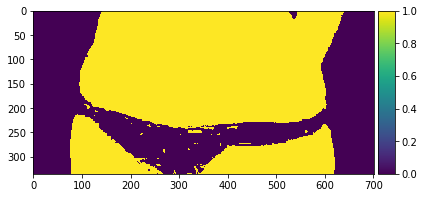

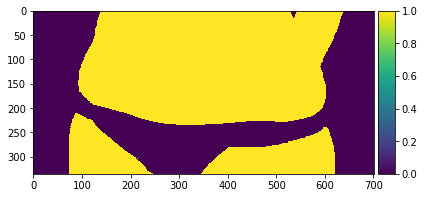

In [75]:
output = np.reshape(preds_test_t,(img.shape[0],img.shape[1]))
plt.show()
imshow(output)
plt.show()
imshow(img)

In [ ]:
feat = dat[0:800000,0:9]
labels = dat[0:800000,9]
labels = (labels > 0).astype(np.uint8)
print(feat.shape)
print(labels.shape)
X = dat[800000:,0:9]
Y = dat[800000:,9]
Y = (Y > 0).astype(np.uint8) 
print(X.shape)
print(Y.shape)